## ERA Session7 Assignment: Model0 => Structure
### Target:
  - Setup a proper structure

### Results:
  - No. of Params: 6,379,786
  - Best Test Accuracy: 99.32%
  - Best Train Accuracy: 99.96

### Analysis:
   - Structure looks fine and model is learning
   - No. of params is too high, so needs to reduce
   - Accuracy looks fine for a basic model

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from models import Model0 as Model

In [3]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                      #  transforms.Resize((28, 28)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

In [4]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

In [5]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [6]:
from torchsummary import summary

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Model().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
            Conv2d-2           [-1, 64, 28, 28]          18,496
         MaxPool2d-3           [-1, 64, 14, 14]               0
            Conv2d-4          [-1, 128, 14, 14]          73,856
            Conv2d-5          [-1, 256, 14, 14]         295,168
         MaxPool2d-6            [-1, 256, 7, 7]               0
            Conv2d-7            [-1, 512, 5, 5]       1,180,160
            Conv2d-8           [-1, 1024, 3, 3]       4,719,616
            Conv2d-9             [-1, 10, 1, 1]          92,170
Total params: 6,379,786
Trainable params: 6,379,786
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 1.51
Params size (MB): 24.34
Estimated Total Size (MB): 25.85
-------------------------------------

In [7]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

epoch_train_loss = []
epoch_train_acc = []
def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)
  epoch_train_loss.append(sum(train_losses[-train_loader.batch_size:])/(train_loader.batch_size))
  epoch_train_acc.append(train_acc[-1])

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [8]:
model =  Model().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 1


Loss=0.09694727510213852 Batch_id=468 Accuracy=88.86: 100%|██████████| 469/469 [00:21<00:00, 22.26it/s]



Test set: Average loss: 0.0648, Accuracy: 9796/10000 (97.96%)

EPOCH: 2


Loss=0.04688159003853798 Batch_id=468 Accuracy=98.41: 100%|██████████| 469/469 [00:20<00:00, 23.13it/s]



Test set: Average loss: 0.0352, Accuracy: 9893/10000 (98.93%)

EPOCH: 3


Loss=0.04045199975371361 Batch_id=468 Accuracy=98.96: 100%|██████████| 469/469 [00:20<00:00, 22.73it/s]



Test set: Average loss: 0.0297, Accuracy: 9907/10000 (99.07%)

EPOCH: 4


Loss=0.03736650198698044 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:19<00:00, 24.12it/s]



Test set: Average loss: 0.0313, Accuracy: 9905/10000 (99.05%)

EPOCH: 5


Loss=0.006399440113455057 Batch_id=468 Accuracy=99.42: 100%|██████████| 469/469 [00:20<00:00, 23.03it/s]



Test set: Average loss: 0.0309, Accuracy: 9905/10000 (99.05%)

EPOCH: 6


Loss=0.06644831597805023 Batch_id=468 Accuracy=99.56: 100%|██████████| 469/469 [00:19<00:00, 23.69it/s]



Test set: Average loss: 0.0360, Accuracy: 9889/10000 (98.89%)

EPOCH: 7


Loss=0.0032765718642622232 Batch_id=468 Accuracy=99.64: 100%|██████████| 469/469 [00:19<00:00, 24.16it/s]



Test set: Average loss: 0.0328, Accuracy: 9908/10000 (99.08%)

EPOCH: 8


Loss=0.01351122185587883 Batch_id=468 Accuracy=99.75: 100%|██████████| 469/469 [00:20<00:00, 23.24it/s]



Test set: Average loss: 0.0289, Accuracy: 9918/10000 (99.18%)

EPOCH: 9


Loss=0.003117382526397705 Batch_id=468 Accuracy=99.80: 100%|██████████| 469/469 [00:20<00:00, 23.07it/s]



Test set: Average loss: 0.0258, Accuracy: 9932/10000 (99.32%)

EPOCH: 10


Loss=0.0037083413917571306 Batch_id=468 Accuracy=99.83: 100%|██████████| 469/469 [00:20<00:00, 22.97it/s]



Test set: Average loss: 0.0297, Accuracy: 9926/10000 (99.26%)

EPOCH: 11


Loss=0.00458223931491375 Batch_id=468 Accuracy=99.88: 100%|██████████| 469/469 [00:19<00:00, 23.48it/s]



Test set: Average loss: 0.0340, Accuracy: 9917/10000 (99.17%)

EPOCH: 12


Loss=0.001431079232133925 Batch_id=468 Accuracy=99.91: 100%|██████████| 469/469 [00:19<00:00, 23.55it/s]



Test set: Average loss: 0.0313, Accuracy: 9913/10000 (99.13%)

EPOCH: 13


Loss=0.0002621734456624836 Batch_id=468 Accuracy=99.86: 100%|██████████| 469/469 [00:20<00:00, 22.78it/s]



Test set: Average loss: 0.0289, Accuracy: 9926/10000 (99.26%)

EPOCH: 14


Loss=4.480867937672883e-05 Batch_id=468 Accuracy=99.91: 100%|██████████| 469/469 [00:20<00:00, 23.21it/s]



Test set: Average loss: 0.0361, Accuracy: 9909/10000 (99.09%)

EPOCH: 15


Loss=0.014139014296233654 Batch_id=468 Accuracy=99.96: 100%|██████████| 469/469 [00:20<00:00, 23.06it/s]



Test set: Average loss: 0.0309, Accuracy: 9920/10000 (99.20%)



Text(0.5, 1.0, 'Test Accuracy')

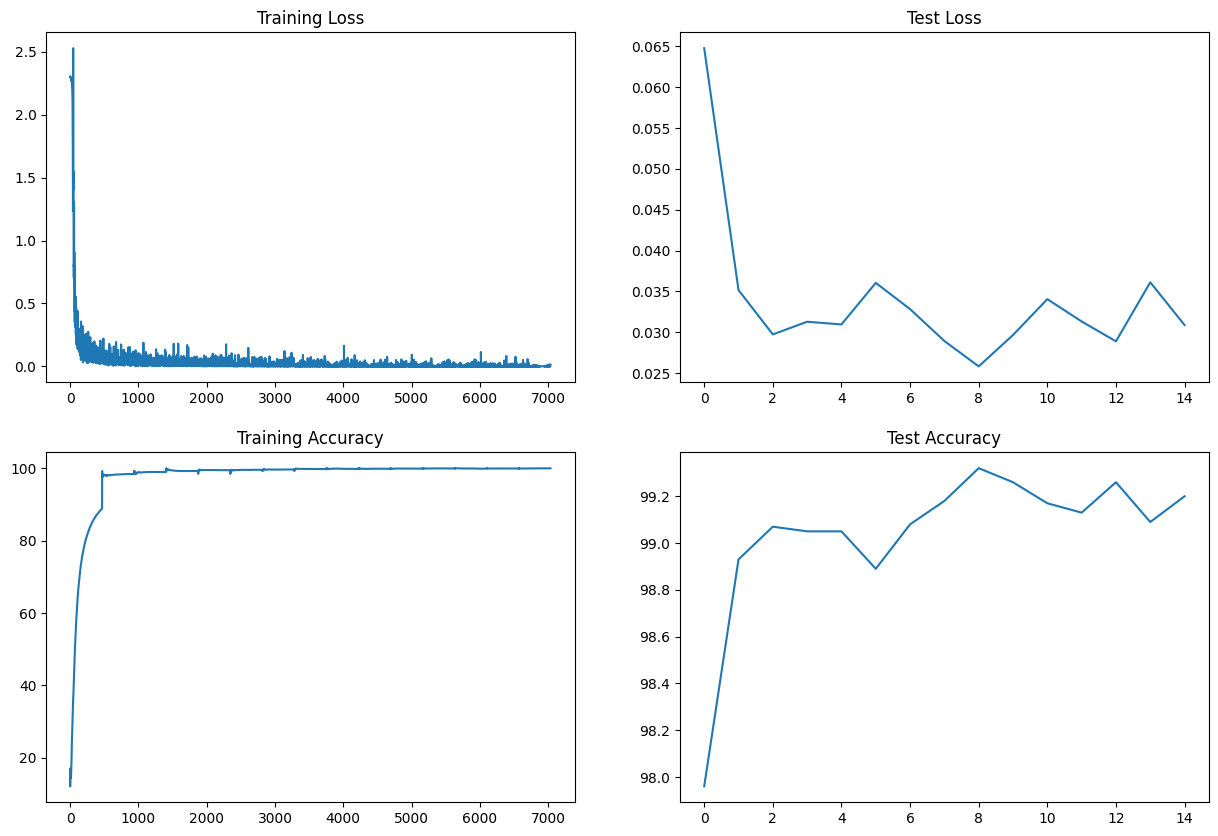

In [9]:
t = [t_items.item() for t_items in train_losses]
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")